# AI Agents for Scientific Simulation and Data Analysis

Computational scientists come from diverse domains and backgrounds, but they tend to use HPC in similar ways: one runs a simulation and processes data, iterating until a new observation emerges. The bulk of scientific reasoning happens in the interpretation of these simulations, but as scientific computation becomes more sophisticated and resource-heavy, researchers can spend undue time on tasks like debugging, environment setup, and convergence checks. Is there a way to automate some of these setup tasks, and allow scientists to focus on refining their hypotheses?

The answer is yes, and the trick is to program an agent to run and execute code. This leaves the agent to handle the cumbersome aspects of numerical work, while the researcher is free to interpret results, come up with new hypotheses, and plan further simulations. In this tutorial we will build an agent that can generate and execute Python code, giving it access to NumPy, SciPy, and a host of other packages for scientific computing. Specifically, we will:

- **Part 1**: Build an agent to write and run Python code
- **Part 2**: Use the agent to write and run a scientific simulation
- **Part 3**: Use the agent to process a scientific dataset

We will build our agent using the basic framework introduced in our first tutorial, with a few key augmentations for code generation. Let's get started!


## Part 1: Build an agent to write and run Python code

The cornerstone of our agent framework is structured generation, and the basic building blocks of our coder-agent will look very familiar those discussed in our first tutorial. That is, we will connect to an LLM backend, setup schema and tool calls for generating python code, and adjust our agent's reasoning loop with these new capabilities. Let's explore each of these broad steps in detail before seeing the completed agent in action.


### Connect to an LLM Backend
```
openai_client = OpenAI(
            api_key="ollama", 
            base_url="http://localhost:11434/v1"
            )
model = from_openai(openai_client, model_name='qwen3-coder:30b')
```
Just like our introductory tutorial, the first step of this demo is to establish an LLM backend. In our case, we will connect to the qwen-coder model running on a local Ollama server, but this choice can be substituted for any model/provider with an OpenAI-compatible endpoint.


### Set up schema for code generation
```
class GenerateCode(BaseModel):
    thoughts: str = Field(..., description="Reasoning about how to solve the coding task")
    code: str = Field(..., description="Python code as a string that solves the task, must include uv install of dependencies")

    def execute(self):
        result = self.run_python_in_docker(self.code)
        return result

class AgentAction(BaseModel):
    thought: str = Field(..., description="Internal reasoning about what to do next.")
    action: Optional[GenerateCode] = Field(None, description="Tool call if calculation is needed.")
    final_summary: Optional[str] = Field(None, description="Final answer to the request when ready.")        
```

Here, we use Pydantic to define two schema for our code generation task. These include GenerateCode, which functions similar to the ToolCall from our initial tutorial, and AgentAction, which functions as a ReAct-style reasoning module. Note that the code generation schema also includes a method called self.action(), which executes the code generated by the schema. Tool calls like this are handled explicitly in the agent's reasoning loop.

### Update the agent's reasoning loop

```
def generate_code_agent(max_steps: int = 3):
    for step in range(0, max_steps):
        response = model(prompt, AgentAction)
        if response.action:
            result = response.action.execute()
            observations.append(result)
        elif response.final_summary:
            return response.final_summary
        else:
            print('Could not formulate next step')
            break
```

Thus far we have given our agent the ability to generate code, but we have yet to tell the agent what to do with it. One way to permit code execution is via explicit tool call in the agent's reasoning loop. If the current step's LLM call returns code, we instruct the agent to execute the code via the GenerateCode schema's self.execute() method. Keep in mind that code generation/execution is generic here; if we wanted to replace GenerateCode with a different tool call, we would need only to write a new schema with the appropriate execute() method. We choose code generation for this tutorial because of the flexibility it provides.

### Update the agent's prompt

```
generate_code_template = Template.from_file('prompt_for_coder_agent.txt')
context = generate_code_template(
                user_task=user_input,
                prev_code=prev_code or "None",
                prev_error=prev_error or "None")
```

Having updated the schema and reasoning loop, the final component of our agent is its prompt. This is where we give the LLM guidelines and explicit instructions regarding how it should populate the fields of our schema. Because we are interested in generating usable code, we update our prompt to include explicit instructions regarding how code should be formatted, along with a simple example script as a template. In general, prompts are problem-dependent, but we find that a short list of requirements and a basic template are sufficient for most coding agents.

With all of the ingredients in place, let's have a look at the complete script:

In [113]:
from outlines import from_openai, Template
from pydantic import BaseModel, Field
from openai import OpenAI
from typing import Optional, List, Dict
import json
import subprocess
import os, uuid
import tempfile

# Connect to an LLM Backend
openai_client = OpenAI(
            api_key="ollama", 
            base_url="http://localhost:11434/v1"
            )
model = from_openai(openai_client, model_name='qwen3-coder:30b')


# Set up schema for code generation, with a class method for executing the code
class GenerateCode(BaseModel):
    thoughts: str = Field(..., description="Reasoning about how to solve the coding task")
    code: str = Field(..., description="Python code as a string that solves the task, must include uv install of dependencies")

    # General action execution method
    def execute(self):
        result = self.run_python_in_docker(self.code)
        return result

    # Specific method for running code in a docker container
    def run_python_in_docker(self,code: str):

        # Write code to script
        tmpdir = tempfile.mkdtemp()
        script_path = os.path.join(tmpdir, "script.py")
        with open(script_path, "w") as f:
            f.write(code)

        # Set up docker container
        container_name = f"code-runner-{uuid.uuid4().hex[:8]}"
        work_dir = os.getcwd()

        # Base docker run command parts
        docker_cmd = ["docker", "run", "--rm", "-v", f"{script_path}:/tmp/script.py:ro",]
        docker_cmd.extend(["-v", f"{work_dir}/data:/data"])
        docker_cmd.extend(["-v", f"{work_dir}/images:/images"])
        docker_cmd.extend(["--name", container_name,"python:3.10-slim","python", "-u", "/tmp/script.py"])
        

        # Run code
        result = subprocess.run(docker_cmd,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,text=True)
        success = (result.returncode == 0)
        output = result.stdout

        # Save a copy of generated code if successful
        if success:
            filename = 'generated_code/' + f"generated_code_{uuid.uuid4().hex[:8]}.py"
            with open(filename, "w", encoding="utf-8") as f:
                f.write(code)

        # Cleanup
        os.remove(script_path)
        os.rmdir(tmpdir)

        # Return code exit status
        return {
            "success": success,
            "output": output,
        }

# Set up schema for reasoning module
class AgentAction(BaseModel):
    thought: str = Field(..., description="Internal reasoning about what to do next.")
    action: Optional[GenerateCode] = Field(None, description="Tool call if code should be generated by the current step.")
    final_summary: Optional[str] = Field(None, description="Final summary when code generation is complete.")          

    
# Main agent reasoning loop
def generate_code_agent(user_input: str, max_steps: int=3):

    # Initialize the prompt with code generation instructions (the full prompt can be found in generate_code_template.txt)
    generate_code_template = Template.from_file('generate_code_template.txt')
    context = generate_code_template(
                user_task=user_input)

    messages: List[Dict] = [{"role": "user", "content": context}]
    observations = []

    # Loop through steps
    for step in range(max_steps):
        print(f"\n--- Step {step + 1} ---")
        prompt = "\n".join([f"{m['role']}: {m['content']}" for m in messages[-4:]])
        if observations:
            prompt += f"\nLatest Observation: {observations[-1]}"

        # Generate structured response
        try:
            response = model(prompt, AgentAction)
            action_obj = (
                response if isinstance(response, AgentAction)
                else AgentAction.model_validate_json(response)
            )
        except Exception as e:
            print(f"Parse error: {e}")
            return {"error": "Generation failed"}

        # Handle tool calls
        if action_obj.action:
            print(f"Thought: {action_obj.thought}")
            tool = action_obj.action
            print(f"Tool Call: {tool.__class__.__name__}")
            result = action_obj.action.execute()

            if result['success']:
                print(f"Code generation returned 'success' with the following output: \n{result['output']}")
                observation = f"Code generation suceeded. Here is the generated code that solved the user's task:\n\n" f"{action_obj.action.code}\n\n" f"Execution result:\n{result['output']}"
                
            else:
                print(f"Code generation failed with the following output: \n{result['output']}")
                observation = f"Code generation failed. Here is the generated code that failed to solve the user's task:\n\n" f"{action_obj.action.code}\n\n" f"Execution result:\n{result['output']}"
            observations.append(observation)    
            
            messages.extend([
                {"role": "assistant", "content": f"Action: {tool.__class__.__name__}"},
                {"role": "system", "content": observation}
            ])
        
        elif action_obj.final_summary:
            print(f"The task is complete. Here is a final summary of my work: \n{action_obj.final_summary}")
            return action_obj.final_summary

        else:
            print("No action or final summary returned.")
            break

    return {"error": f"Max steps ({max_steps}) reached without generated code"}    
    
# Simple test case
user_input = "Generate a Python Code that adds two integers. Use the code to answer: 1+1=?"
result = generate_code_agent(user_input = user_input, max_steps = 3)



--- Step 1 ---
Thought: The user wants a Python code that adds two integers, specifically 1+1. I need to generate a simple Python script that performs this addition. Since this is a basic task, no external dependencies or complex logic is required. I will create the code directly without needing to install any packages via uv.
Tool Call: GenerateCode
Code generation returned 'success' with the following output: 
1 + 1 = 2


--- Step 2 ---
The task is complete. Here is a final summary of my work: 
The Python code for adding two integers has been generated and executed. The result of 1+1 is 2.


Note that our GenerateCode action has been configured such that any executed code is saved in the generated_code folder. We can check the contents of this folder, and see that the agent did indeed write a code that answers our request.

## Part 2:  Use the agent to write and run a scientific simulation

The framework above is simple but powerful. By giving the agent authority to execute Python, many scientific computing tasks reduce to communicating domain-specific requirements through the prompt and tool handling. This is one reason why 'prompt engineering' has become such a popular topic in recent years. The user can ask the agent simple request like 'use python to run a fluid dynamics simulation" and the agent in theory has the tools to write and execute such a script without further intervention.

For some scientific disciplines, this degree of autonomy presents an issue. Particularly in the case of compute-heavy simulations (e.g., fluid dynamics, computational chemistry, structural mechanics), one risks draining computational resources if the setup parameters are chosen carelessly. What's more, legacy simulation codes often lack complete documentation, making it even harder to setup guardrails for the agent. This is the domain of bespoke coding agents, in which an agent's prompt, tools, and reasoning modules are heavily refined for tasks native to a specific sub-domain. 

In this part of the tutorial, we will stick to very simple, canonical simulations that a general-purpose coding agents. Specifically, we draw an example from fluid dynamics, and ask the agent to simulate the collision of two point vortices using potential flow, a classic problem with many existing implementations. This will give us a taste of what an agent can perform out-of-the-box, while also demonstrating how to begin incorporating domain-specific constraints.

In [125]:
# Let's try to incorporate domain-specific knowledge via the prompt
user_input = "Generate a Python Code that simulates the collision of two point vortices moving toward one another at time 0. \
Advance the simulation until the two vortices collide. \
Save 10 flowfields regularly spaced in time from the simulation. \
Return output flowfields to me in a file called output.mat. This file should be located in the /data directory. \
Return output images to me as png's. These should be stored in the /images directory. \
"
result = generate_code_agent(user_input = user_input, max_steps = 3)



--- Step 1 ---
Thought: The user wants a Python simulation of two point vortices moving towards each other, simulating their collision. The simulation should save 10 flowfields at regular time intervals and output them as a .mat file in /data directory, along with corresponding PNG images in /images directory. I need to generate a complete script that handles vortex dynamics, integrates the motion, saves flowfields, and outputs to the specified locations. First, I'll install uv and required dependencies, then implement the simulation code.
Tool Call: GenerateCode
Code generation returned 'success' with the following output: 
Simulation completed. Flowfields saved to /data/output.mat and images to /images directory.


--- Step 2 ---
The task is complete. Here is a final summary of my work: 
The simulation of two interacting vortices has been completed successfully. The code computes the vortex trajectories, generates 10 flowfield visualizations saved as PNG images in the /images direct

We can look in the output directory and see exactly what the agent has returned as its simulation.

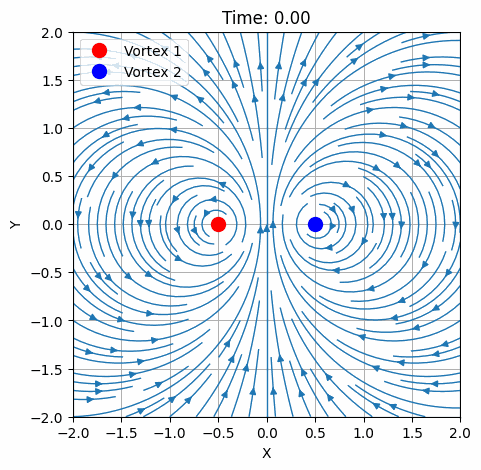

In [126]:
from PIL import Image
import glob
from IPython.display import Image as IPImage, display

# Get PNG files (adjust path / sort as needed)
png_files = sorted(glob.glob("images/*.png"))

frames = [Image.open(p) for p in png_files]

# Save as GIF
frames[0].save(
    "animation.gif",
    save_all=True,
    append_images=frames[1:],
    duration=200,  # milliseconds per frame
    loop=0         # 0 = infinite loop
)

# Display gif within Jupyter
display(IPImage(filename="animation.gif"))    

Based on the image sequence above, the agent was indeed able to complete a potential flow simulation, albeit with some questionable image formatting. There are several important observations regarding this outcome: 

- Depending on your back-end model, the agent may have needed several attempts before successfully completing the simulation. This is expected to some degree and demonstrates a key feature of AI agents: they incorporate observations from previous actions into their plan for next steps. This is one of the core traits that differentiates AI agent from LLM's.
- Notice that the user input description was quite extensive, even for this very simple simulation! One can imagine that if we had asked the agent to write a finite volume solver, the number of failure modes would increase quite a bit, and restrictions in the prompt would need to become more extensive. 

## Part 3: Use the agent to process a scientific dataset

The previous section gave some insight into running simulations with an AI agent, identifying areas where that process is easy (launching a general simulation) and difficult (implementing domain-specific guardrails). Many of these strengths and weaknesses also apply to the next step in a scientific workflow: data analysis. With its coding capabilities, an AI agent is capable of accessing and computing statistics using the data output from a scientific simulation, making it a natural fit for rapid data processing.

In this part of the tutorial, we will use our coding-agent to interact with VORTALL.mat, a custom file output from a high-resolution fluid dynamics simulation. As we saw with our simulation runs, we will find that the agent succeeds most consistently on general data science requests (linear regression, PCA, etc.) and struggles with more domain-specific tasks.


In [127]:
# We'll start by asking the agent to open the file for us and returning its size
user_input = "There is a file located in /data called VORTALL.mat. \
Please tell me the size (in GB) of the file and the shape of the data within it. \
"

result = generate_code_agent(user_input = user_input, max_steps = 3)


--- Step 1 ---
Thought: The user wants to determine the size of a file named VORTALL.mat located in /data and also wants to know the shape of the data within it. First, I need to check the file size using Python's os module. Then, I need to load the .mat file to determine its data shape. Since the file is a .mat file, which is typically used for MATLAB data, I will need to use scipy.io to load it. The code needs to install required dependencies like scipy using uv. I'll start by generating the necessary code.
Tool Call: GenerateCode
Code generation returned 'success' with the following output: 
File size: 0.096034 GB
Data keys in the .mat file:
Key: VORTALL, Shape: (89351, 151)


--- Step 2 ---
The task is complete. Here is a final summary of my work: 
The file VORTALL.mat is 0.096034 GB in size. The data within it has a key 'VORTALL' with a shape of (89351, 151).


Great! The agent was able to find the file, learn its shape (via code), and communicate its finding back to us. We are now free to use that information in deciding our next processing steps. For example, we may be interested in knowing how complex the data is before deciding what to do with it. Let's see if the agent can implemenet a common complexity measure like PCA.

In [131]:
# We'll start by asking the agent to open the file for us and returning its size
user_input = "There is a file located in /data called VORTALL.mat. \
Please perform PCA on the data and return a plot of cumulative variance for the first 10 modes. \
Save this plot in /images/cumulative_var.png. \
"

result = generate_code_agent(user_input = user_input, max_steps = 3)


--- Step 1 ---
Thought: The user wants to perform PCA on data from a .mat file and plot the cumulative variance for the first 10 modes. I need to generate Python code that loads the .mat file, performs PCA using numpy/scipy, calculates cumulative variance, and saves a plot. Since this involves scientific computing, I'll include numpy, scipy, and matplotlib in the dependencies. First, I'll install uv, then the required packages, then load the .mat file, perform PCA, compute cumulative variance, and save the plot to the specified path.
Tool Call: GenerateCode
Code generation returned 'success' with the following output: 
Plot saved to /images/cumulative_var.png


--- Step 2 ---
The task is complete. Here is a final summary of my work: 
The PCA has been performed on the data from /data/VORTALL.mat, and the cumulative variance plot for the first 10 modes has been saved as /images/cumulative_var.png.


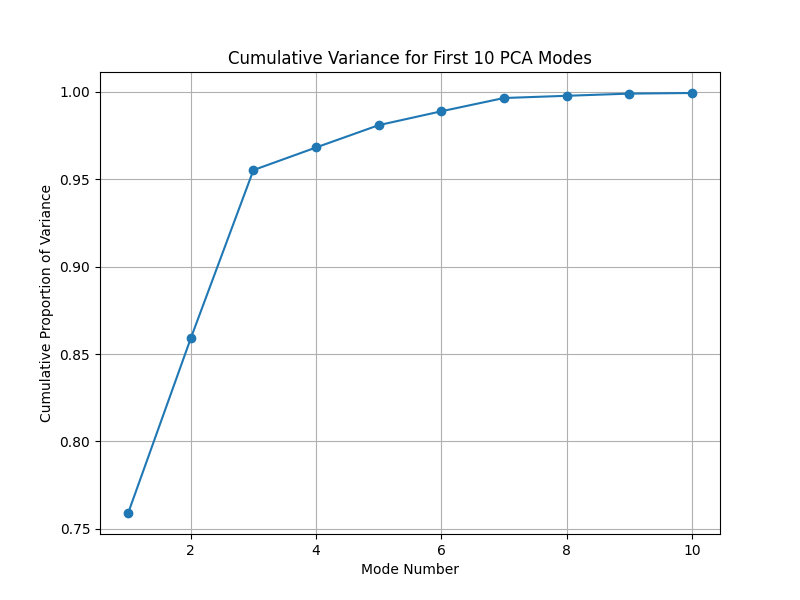

In [133]:
# Let's see what the agent has generated for us
from IPython.display import Image, display

display(Image(filename="images/cumulative_var.png"))

An interesting result! The agent has successfully returned a cumulative variance plot, and it would seem to suggest that our dataset is relatively straightfoward. According to the output figure, variance within the data is well-captured by less than 5 modes. Let's also perform this computation ourselves to confirm that the agent hasn't made any mistakes.

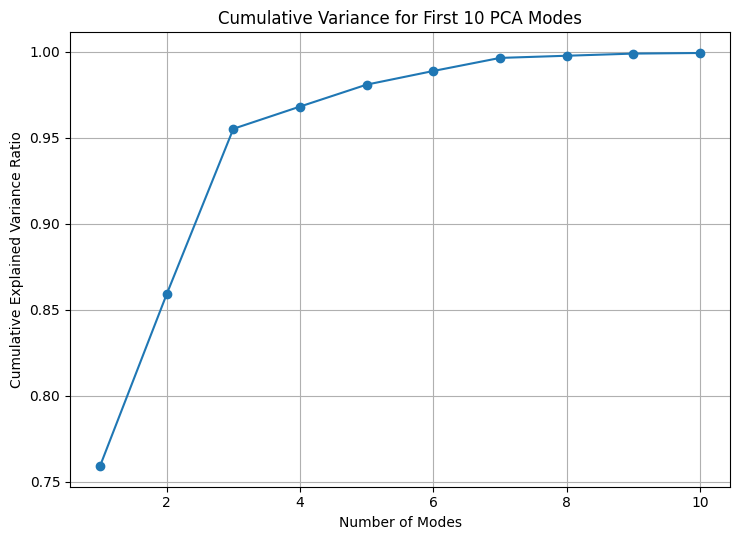

In [136]:
from scipy.io import loadmat
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data
data = loadmat('./data/VORTALL.mat')['VORTALL']
    
# Perform PCA
pca = PCA(n_components=10)
pca.fit(data)

# Compute cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(7.5, 5.5))
plt.plot(range(1, min(11, len(cumulative_variance)+1)), cumulative_variance[:10], marker='o')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Variance for First 10 PCA Modes')
plt.grid(True)
plt.tight_layout()
plt.show()

This is exactly the same plot that was returned by the agent, which speaks to its ability to perform basic statistics.

As a final check, let's see if we can push the agent toward more complex data analysis tasks. 

In [138]:
# We'll start by asking the agent to open the file for us and returning its size
user_input = "There is a file located in /data called VORTALL.mat. \
Please perform PCA analysis on this dataset. Use the first ten modes to build a Galerkin projection model for the Navier Stokes. \
"
result = generate_code_agent(user_input = user_input, max_steps = 3)


--- Step 1 ---
Thought: I need to generate Python code to perform PCA analysis on the VORTALL.mat dataset and then use the first ten modes to build a Galerkin projection model for the Navier-Stokes equations. First, I'll install the required dependencies including scipy, numpy, and matplotlib using uv pip install. Then, I'll write the main code to load the data, perform PCA, and build the Galerkin model. I need to ensure that all imports happen after the package installation.
Tool Call: GenerateCode
Code generation failed with the following output: 
Traceback (most recent call last):
  File "/tmp/script.py", line 75, in <module>
    main()
  File "/tmp/script.py", line 31, in main
    from sklearn.decomposition import PCA
ModuleNotFoundError: No module named 'sklearn'


--- Step 2 ---
Thought: The previous code failed because 'sklearn' was not installed. I need to update the required packages list to include 'scikit-learn' which contains the PCA module. The rest of the logic seems cor

Ah, we've run into something that the agent consistently fails. In this case, the agent was set up for failure; even if it had built a model, the Galerkin projection approach is unstable for the modes extracted from a cylinder at this Re. However, knowing what we now know about agents, we can see a path forward: refining the prompt, enhancing the reasoning module, or nesting additional schema into GenerateCode are all valid paths toward a domain-specific tasks like this.